In [1]:
from __future__ import print_function
import torch
import torch.nn.functional as F
from torch import nn, optim, cuda
from torchvision import datasets, transforms
from torch.autograd import Variable

In [2]:
# GPU settings
device = 'cuda' if cuda.is_available() else 'cpu'
print("Device: ", device, "\n");

Device:  cuda 



In [3]:
# Training settings
batch_size = 256 

# CIFER10 Dataset
# train_dataset nomalize
train_dataset = datasets.CIFAR10(root='./data',
                              train=True,
                              transform=transforms.ToTensor(),
                              download=True)

print("data shape:", train_dataset.data.shape)

train_mean = train_dataset.data.mean(axis=(0, 1, 2))
train_std = train_dataset.data.std(axis=(0, 1, 2))

train_mean = train_mean / 255
train_std = train_std / 255

print("train_mean:", train_mean)
print("train_std:", train_std)

100%|██████████| 170498071/170498071 [00:04<00:00, 35949490.25it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
data shape: (50000, 32, 32, 3)
train_mean: [0.49139968 0.48215841 0.44653091]
train_std: [0.24703223 0.24348513 0.26158784]


In [4]:
# test_dataset nomalize
test_dataset = datasets.CIFAR10(root='./data/',
                              train=False,
                              transform=transforms.ToTensor())

print("data shape:", test_dataset.data.shape)

test_mean = test_dataset.data.mean(axis=(0, 1, 2))
test_std = test_dataset.data.std(axis=(0, 1, 2))

test_mean = test_mean / 255
test_std = test_std / 255

print("test_mean:", test_mean)
print("test_std:", test_std)

data shape: (10000, 32, 32, 3)
test_mean: [0.49421428 0.48513139 0.45040909]
test_std: [0.24665252 0.24289226 0.26159238]


In [5]:
# load
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(test_mean, test_std)
])

train_dataset = datasets.CIFAR10(root='./data',
                              train=True,
                              transform=train_transform,
                              download=True)
test_dataset = datasets.CIFAR10(root='./data/',
                              train=False,
                              transform=test_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

Files already downloaded and verified


In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1) # /stride
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True) # inplace 옵션의 역할이 무엇인가?
        self.conv2 =  nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1) # 
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride
        self.im = lambda x: x # identity mapping

    def forward(self, x):
        residual=self.im(x)
        if self.downsample is not None:
            residual = self.downsample(residual)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += residual
        out = self.relu(out)
        return out

In [7]:
class ResNet_CIFAR10(nn.Module):
    def __init__(self, block, layers, zero_init_residual=False):
        super(ResNet_CIFAR10, self).__init__()
        self.in_channels = 64
        # 3, 32, 32
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False) # bias?????????????????????
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True) # inplace???????????????
        self.mp = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # 64, 32, 32
        self.layer1 = self._make_layer(block, 64, layers[0])
        # 64, 32, 32
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        # 128, 16, 16
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        # 256, 8, 8
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        # 512, 4, 4
        self.ap = nn.AdaptiveAvgPool2d((1, 1))
        # 512, 1, 1
        self.fc = nn.Linear(512, 10)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)
    
    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1: 
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, 1, stride),
                nn.BatchNorm2d(out_channels),#??????????
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        
        self.in_channels = out_channels
        
        for _ in range(1, blocks): 
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)
    

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.mp(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.ap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x)
        return x

model = ResNet_CIFAR10(ResidualBlock, [2, 2, 2, 2]) # ResNet20
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5) 

In [8]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # data, target = Variable(data), Variable(target)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [9]:
def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # data, target = Variable(data, volatile=True), Variable(target)
        data, target = data.to(device), target.to(device)
        output = model(data)
        # sum up batch loss
        test_loss += F.nll_loss(output, target, size_average=False).data
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('Test set({}): Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        epoch, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

<ipython-input-7-a9ca00db8409>:73: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.479803
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.838874


/usr/local/lib/python3.9/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set(1): Average loss: 1.7188, Accuracy: 3616/10000 (36%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.620825
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.585295
Test set(2): Average loss: 1.4664, Accuracy: 4471/10000 (45%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.442098
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.403310
Test set(3): Average loss: 1.3374, Accuracy: 5124/10000 (51%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.229727
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.227149
Test set(4): Average loss: 1.2444, Accuracy: 5480/10000 (55%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.246244
Train Epoch: 5 [25600/50000 (51%)]	Loss: 1.098435
Test set(5): Average loss: 1.2783, Accuracy: 5505/10000 (55%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 1.135929
Train Epoch: 6 [25600/50000 (51%)]	Loss: 1.144717
Test set(6): Average loss: 1.1388, Accuracy: 5967/10000 (60%)

Train Epoch: 7 [0/50000 (0%)]	Loss: 1.034418
Train Epoch: 7 [25600/50000 (51%)]	Loss: 1.099255
Test set(7): Average loss: 1.1153, Accuracy: 6071/10

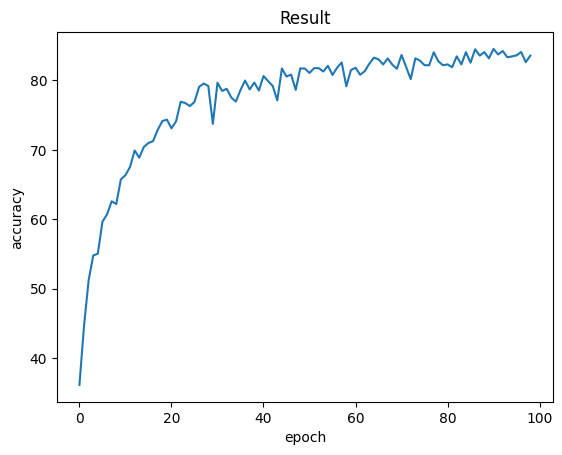

In [10]:
accuracy=[]
for epoch in range(1, 100):
    train(epoch)
    accuracy.append(test(epoch))

%matplotlib inline
from matplotlib import pyplot as plt
plt.plot([i for i in range(len(accuracy))], accuracy)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Result')
plt.show()

In [12]:
max(accuracy)

tensor(84.5300)